<a href="https://colab.research.google.com/github/kmeng01/rome/blob/main/notebooks/causal_trace.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" align="left"/></a>&nbsp;or in a local notebook.

In [ ]:
# If running in colab

In [ ]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
cd /content && rm -rf /content/memit
git clone https://github.com/kmeng01/memit memit > install.log 2>&1
pip install -r /content/memit/scripts/colab_reqs/rome.txt >> install.log 2>&1
pip install --upgrade google-cloud-storage >> install.log 2>&1

In [ ]:
IS_COLAB = True
try:
    import google.colab
    import torch
    import os

    IS_COLAB = True
    os.chdir("/content/memit")
    if not torch.cuda.is_available():
        raise Exception("Change runtime type to include a GPU.")
except ModuleNotFoundError as _:
    pass

## Causal Tracing

In [ ]:
!pip install transformers
!pip install datasets
!pip install accelerate

In [ ]:
import os, re, json
import torch, numpy
from collections import defaultdict
from util import nethook
from util.globals import DATA_DIR
from experiments.causal_trace import (
    ModelAndTokenizer,
    layername,
    guess_subject,
    plot_trace_heatmap,
)
from experiments.causal_trace import (
    make_inputs,
    decode_tokens,
    find_token_range,
    predict_token,
    predict_from_input,
    collect_embedding_std,
)
from dsets import KnownsDataset

torch.set_grad_enabled(False)

Now we load a model and tokenizer, and show that it can complete a couple factual statements correctly.

In [ ]:
model_name = "gpt2-xl"  
mt = ModelAndTokenizer(
    model_name,
    low_cpu_mem_usage=IS_COLAB,
    torch_dtype=(torch.float16 if "20b" in model_name else None),
)

In [ ]:
knowns = KnownsDataset(DATA_DIR)  # Dataset of known facts
noise_level = 3 * collect_embedding_std(mt, [k["subject"] for k in knowns])
print(f"Using noise level {noise_level}")


data/known_1000.json does not exist. Downloading from https://memit.baulab.info/data/dsets/known_1000.json


100%|██████████| 335k/335k [00:00<00:00, 2.05MB/s]


Loaded dataset with 1209 elements
Using noise level 0.13462981581687927


In [ ]:
def trace_with_patch(
    model,  # The model
    inp,  # A set of inputs
    states_to_patch,  # A list of (token index, layername) triples to restore
    answers_t,  # Answer probabilities to collect
    tokens_to_mix,  # Range of tokens to corrupt (begin, end)
    noise=0.1,  # Level of noise to add
    trace_layers=None,  # List of traced outputs to return
):
    prng = numpy.random.RandomState(1)  # For reproducibility, use pseudorandom noise
    patch_spec = defaultdict(list)
    for t, l in states_to_patch:
        patch_spec[l].append(t)
    embed_layername = layername(model, 0, "embed")

    def untuple(x):
        return x[0] if isinstance(x, tuple) else x

    # Define the model-patching rule.
    def patch_rep(x, layer):
        if layer == embed_layername:
            # If requested, we corrupt a range of token embeddings on batch items x[1:]
            if tokens_to_mix is not None:
                b, e = tokens_to_mix
                x[1:, b:e] += noise * torch.from_numpy(
                    prng.randn(x.shape[0] - 1, e - b, x.shape[2])
                ).to(x.device)
            return x
        if layer not in patch_spec:
            return x
        # If this layer is in the patch_spec, restore the uncorrupted hidden state
        # for selected tokens.
        h = untuple(x)
        for t in patch_spec[layer]:
            h[1:, t] = h[0, t]
        return x

    # With the patching rules defined, run the patched model in inference.
    additional_layers = [] if trace_layers is None else trace_layers
    with torch.no_grad(), nethook.TraceDict(
        model,
        [embed_layername] + list(patch_spec.keys()) + additional_layers,
        edit_output=patch_rep,
    ) as td:
        outputs_exp = model(**inp)

    # We report softmax probabilities for the answers_t token predictions of interest.
    probs = torch.softmax(outputs_exp.logits[1:, -1, :], dim=1).mean(dim=0)[answers_t]

    # If tracing all layers, collect all activations together to return.
    if trace_layers is not None:
        all_traced = torch.stack(
            [untuple(td[layer].output).detach().cpu() for layer in trace_layers], dim=2
        )
        return probs, all_traced

    return probs

In [ ]:
def calculate_hidden_flow(
    mt, prompt, subject, samples=10, noise=0.1, window=10, kind=None
):
    """
    Runs causal tracing over every token/layer combination in the network
    and returns a dictionary numerically summarizing the results.
    """
    inp = make_inputs(mt.tokenizer, [prompt] * (samples + 1))
    with torch.no_grad():
        answer_t, base_score = [d[0] for d in predict_from_input(mt.model, inp)]
    [answer] = decode_tokens(mt.tokenizer, [answer_t])
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)
    low_score = trace_with_patch(
        mt.model, inp, [], answer_t, e_range, noise=noise
    ).item()
    if not kind:
        differences = trace_important_states(
            mt.model, mt.num_layers, inp, e_range, answer_t, noise=noise
        )
    else:
        differences = trace_important_window(
            mt.model,
            mt.num_layers,
            inp,
            e_range,
            answer_t,
            noise=noise,
            window=window,
            kind=kind,
        )
    differences = differences.detach().cpu()
    return dict(
        scores=differences,
        low_score=low_score,
        high_score=base_score,
        input_ids=inp["input_ids"][0],
        input_tokens=decode_tokens(mt.tokenizer, inp["input_ids"][0]),
        subject_range=e_range,
        answer=answer,
        window=window,
        kind=kind or "",
    )


def trace_important_states(model, num_layers, inp, e_range, answer_t, noise=0.1):
    ntoks = inp["input_ids"].shape[1]
    table = []
    for tnum in range(ntoks):
        row = []
        for layer in range(0, num_layers):
            r = trace_with_patch(
                model,
                inp,
                [(tnum, layername(model, layer))],
                answer_t,
                tokens_to_mix=e_range,
                noise=noise,
            )
            row.append(r)
        table.append(torch.stack(row))
    return torch.stack(table)


def trace_important_window(
    model, num_layers, inp, e_range, answer_t, kind, window=10, noise=0.1
):
    ntoks = inp["input_ids"].shape[1]
    table = []
    for tnum in range(ntoks):
        row = []
        for layer in range(0, num_layers):
            layerlist = [
                (tnum, layername(model, L, kind))
                for L in range(
                    max(0, layer - window // 2), min(num_layers, layer - (-window // 2))
                )
            ]
            r = trace_with_patch(
                model, inp, layerlist, answer_t, tokens_to_mix=e_range, noise=noise
            )
            row.append(r)
        table.append(torch.stack(row))
    return torch.stack(table)

## Code to plot the results

In [ ]:
def plot_hidden_flow(
    mt,
    prompt,
    subject=None,
    samples=10,
    noise=0.1,
    window=10,
    kind=None,
    modelname=None,
    savepdf=None,
):
    if subject is None:
        subject = guess_subject(prompt)
    result = calculate_hidden_flow(
        mt, prompt, subject, samples=samples, noise=noise, window=window, kind=kind
    )
    plot_trace_heatmap(result, savepdf, modelname=modelname)


def plot_all_flow(mt, prompt, subject=None, noise=0.1, modelname=None):
    for kind in [None, "mlp", "attn"]:
        plot_hidden_flow(
            mt, prompt, subject, modelname=modelname, noise=noise, kind=kind
        )

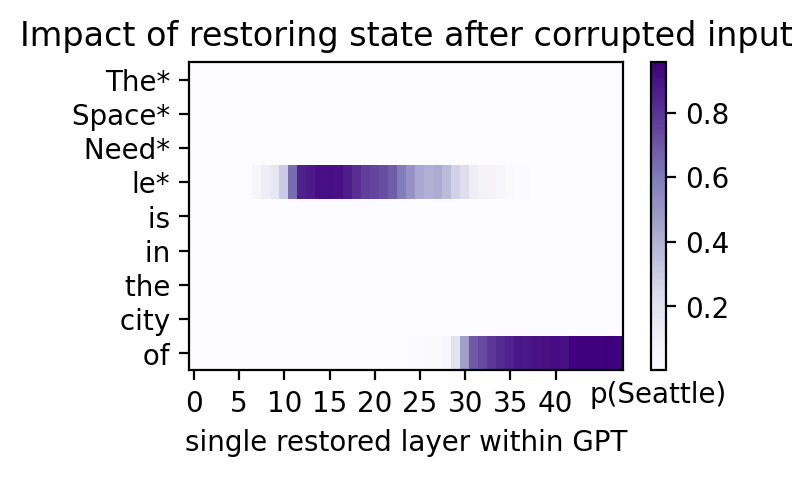

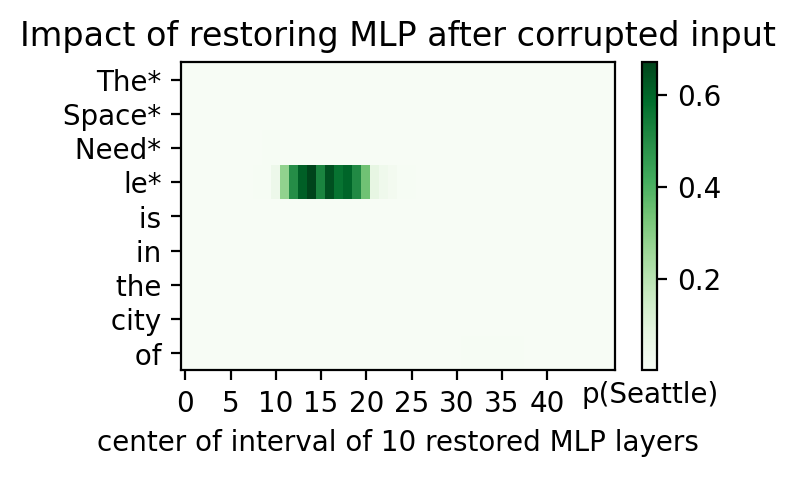

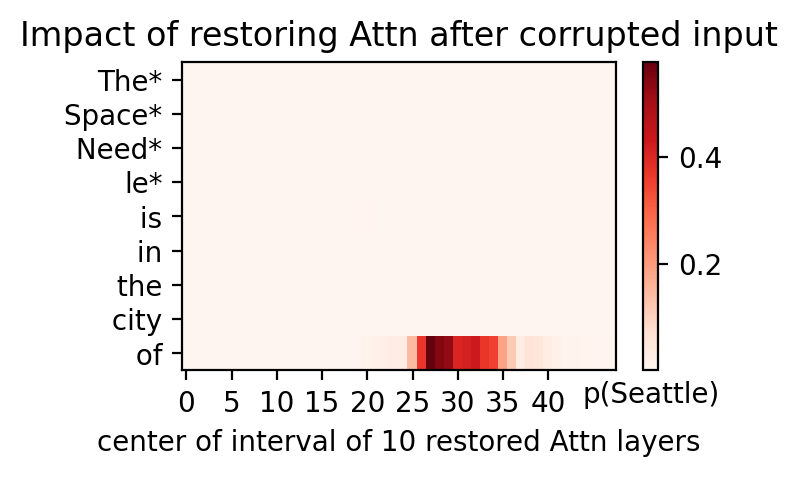

In [ ]:
plot_all_flow(mt, "The Space Needle is in the city of", noise=noise_level)

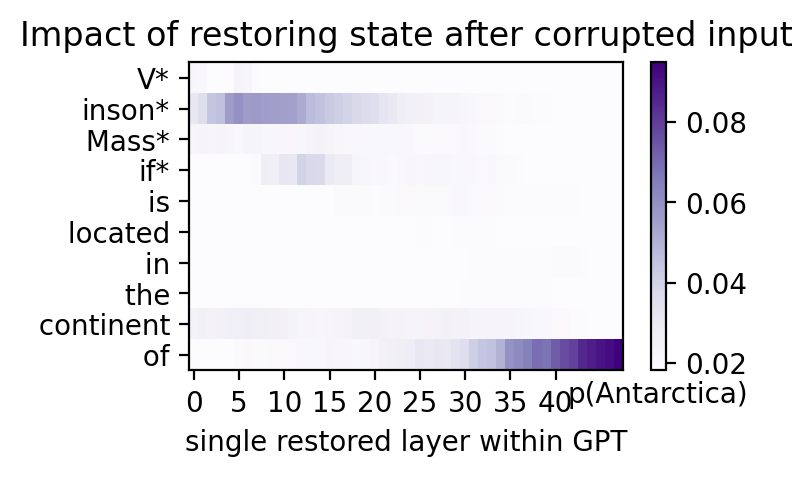

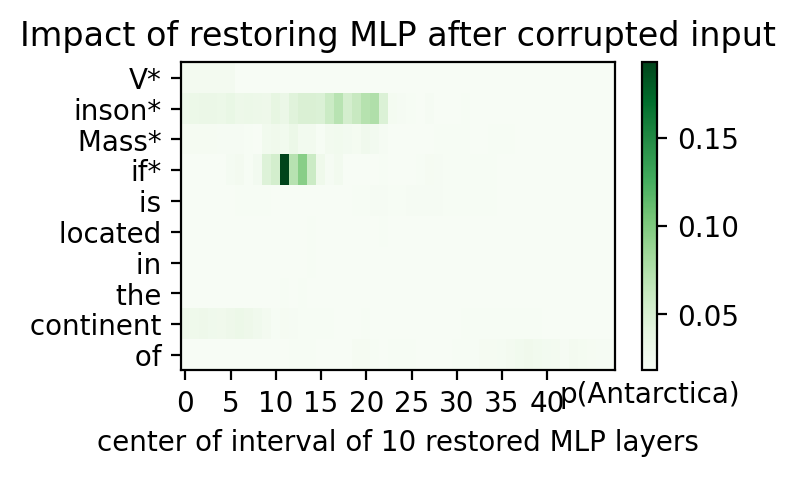

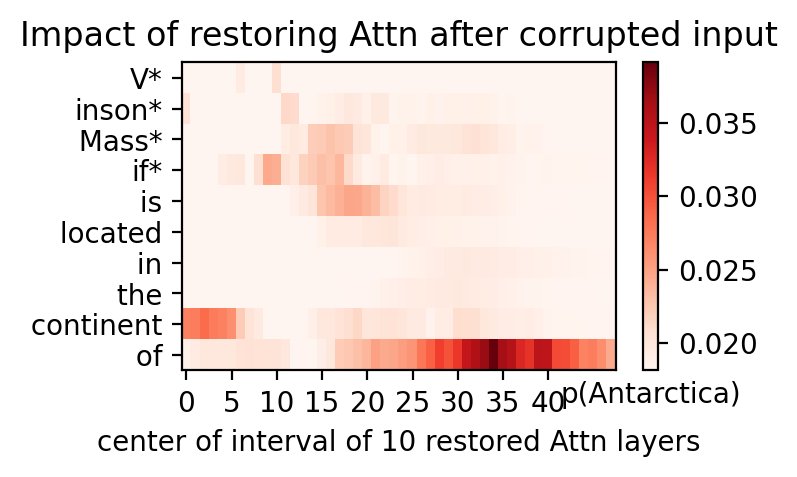

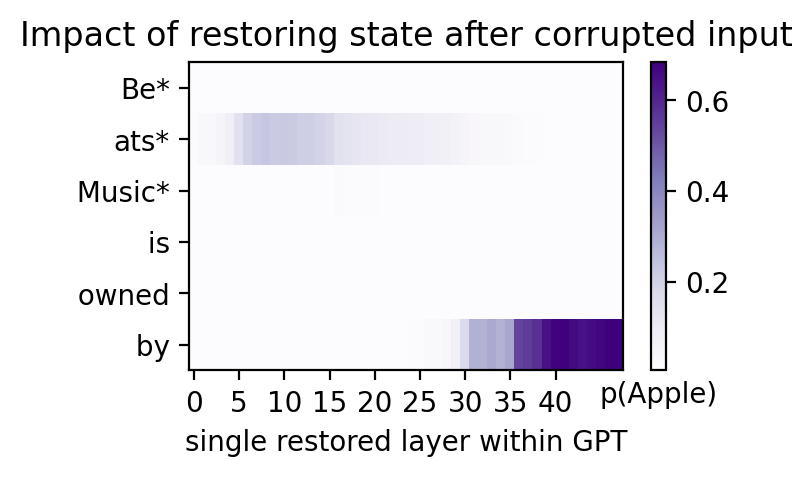

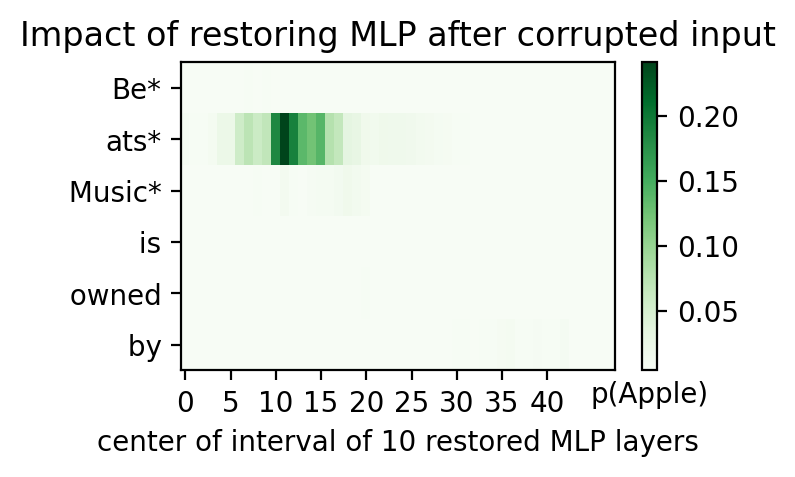

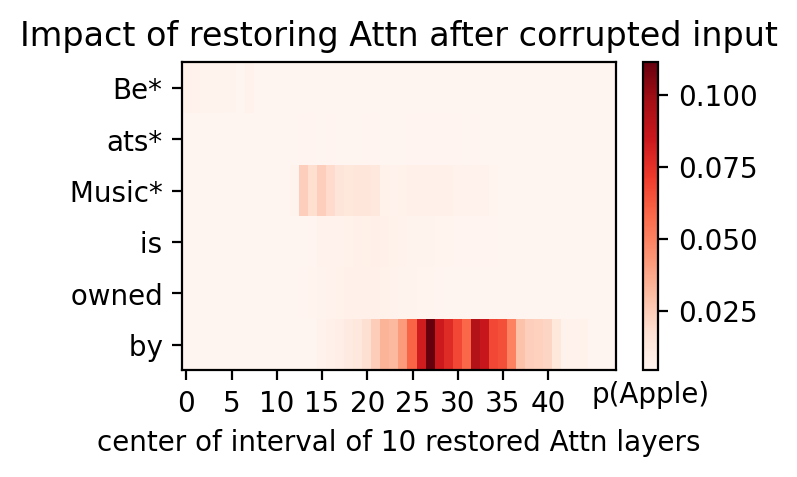

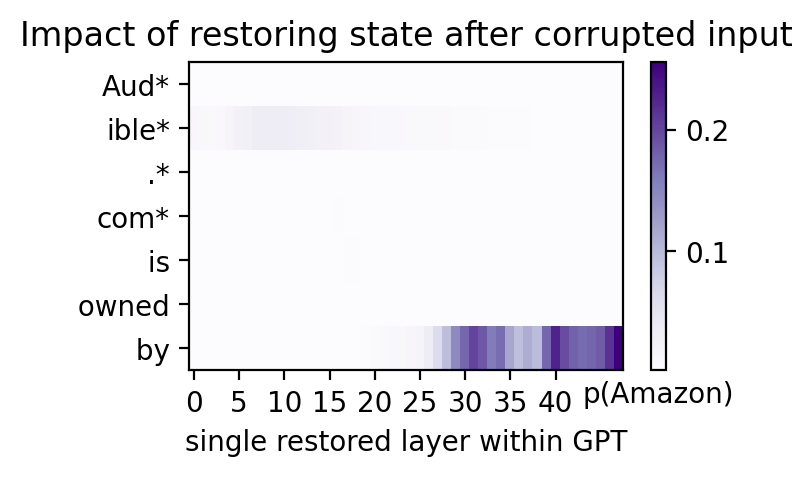

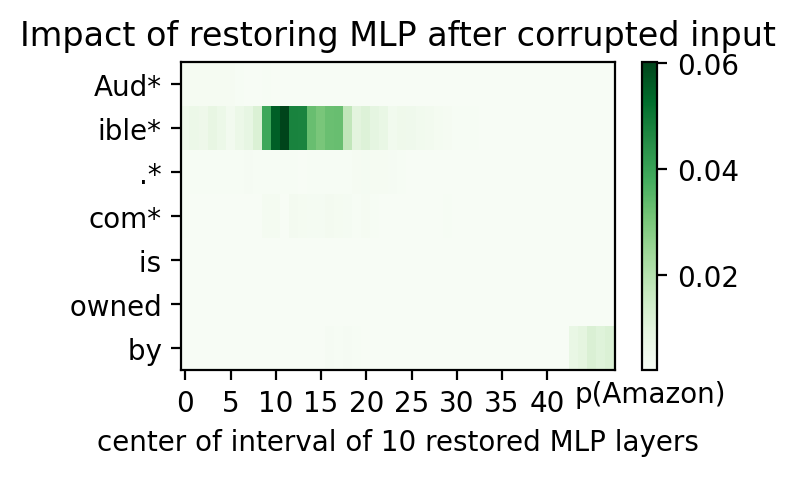

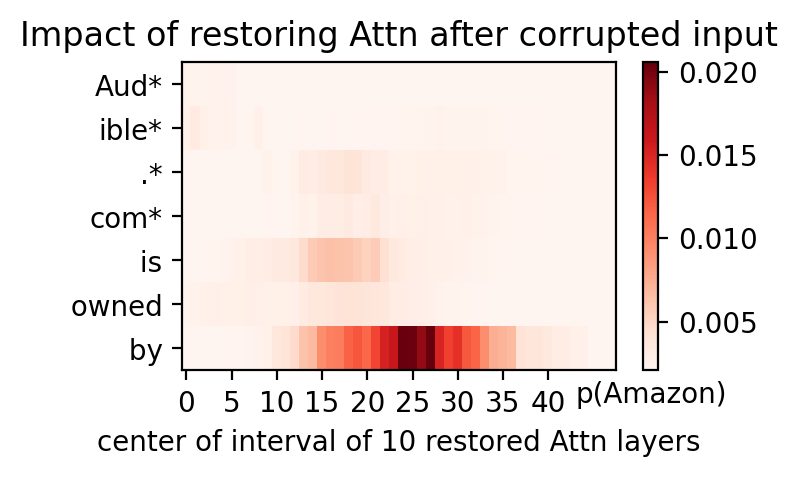

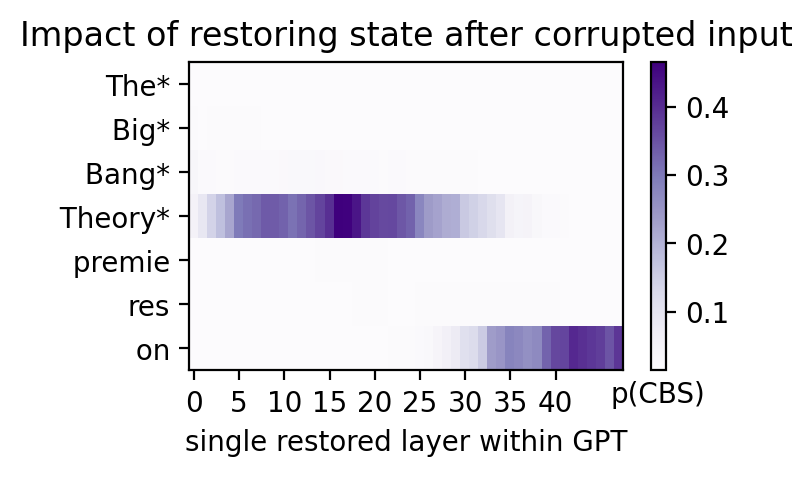

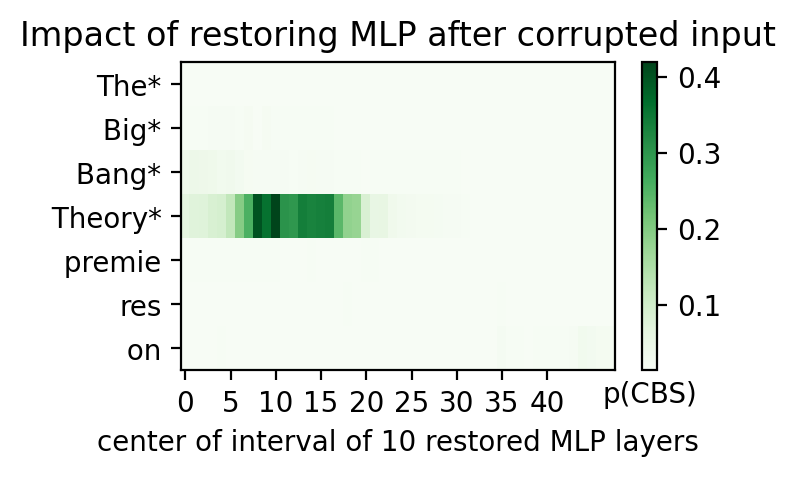

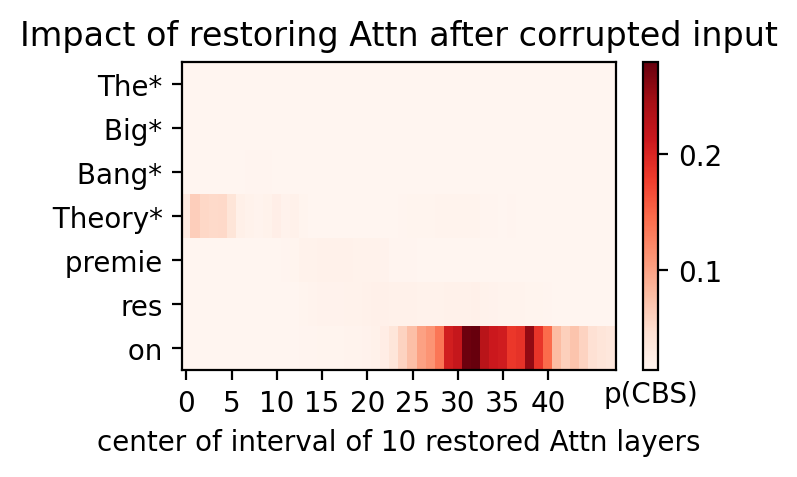

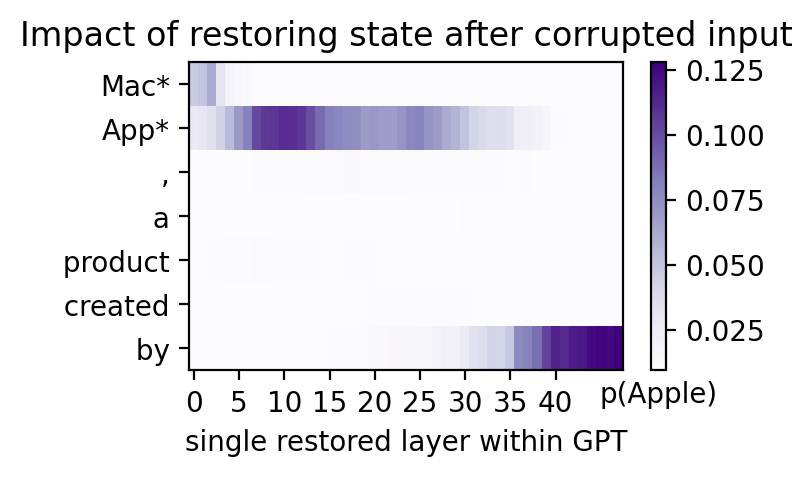

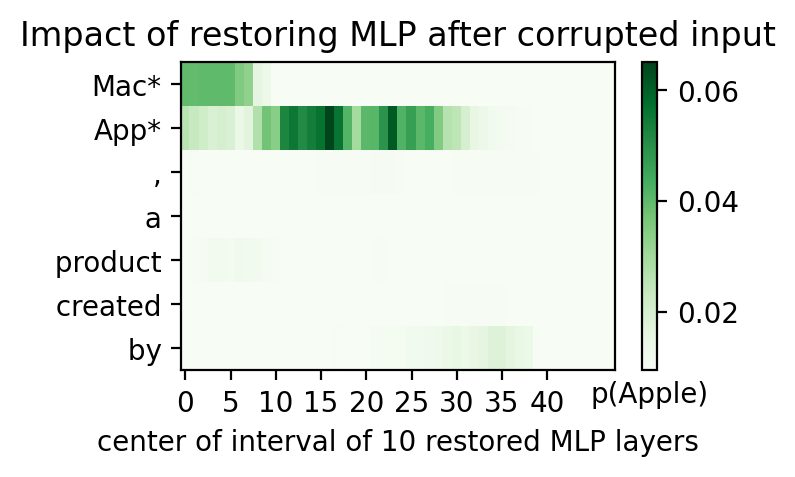

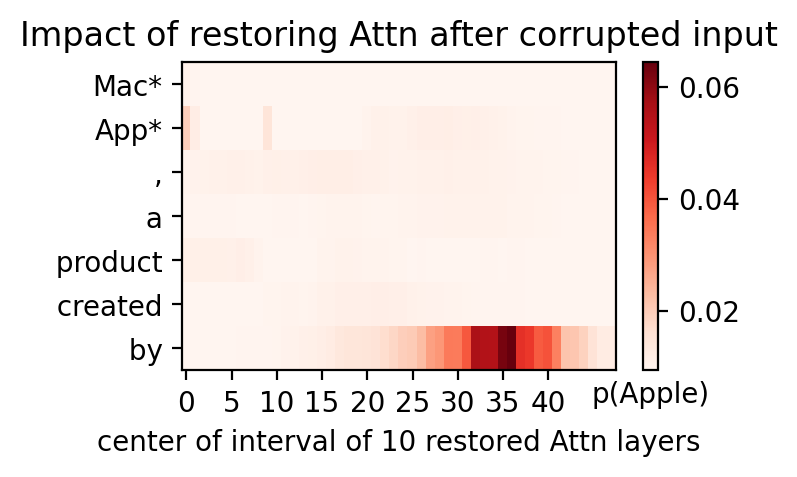

In [ ]:
for knowledge in knowns[:5]:
    plot_all_flow(mt, knowledge["prompt"], knowledge["subject"], noise=noise_level)

In [ ]:
# Checking the modules of the GPT2XL transformer

In [ ]:
mt.model.modules

<bound method Module.modules of GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1600)
    (wpe): Embedding(1024, 1600)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-47): 48 x GPT2Block(
        (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1600, out_features=50257, bias=False)
)>

In [ ]:
mlp_layers_list = []
for i in range(48):
    mlp_layers_list.append('transformer.h.'+ str(i)+'.mlp')
mlp_layers_list[:5]

['transformer.h.0.mlp',
 'transformer.h.1.mlp',
 'transformer.h.2.mlp',
 'transformer.h.3.mlp',
 'transformer.h.4.mlp']

In [ ]:
prompt = "The Space Needle is in the city of;'"
samples = 0   #0
subject= None
noise = 0.1    #0
kind = None

subject = guess_subject(prompt)

inp = make_inputs(mt.tokenizer, [prompt] * (samples + 1))
with torch.no_grad():
    answer_t, base_score = [d[0] for d in predict_from_input(mt.model, inp)]
[answer] = decode_tokens(mt.tokenizer, [answer_t])
e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)

tokens = mt.tokenizer(prompt)


probs,all_traced = trace_with_patch(
    model = mt.model,  # The model
    inp = inp,  # A set of inputs
    states_to_patch = [],  # A list of (token index, layername) triples to restore
    answers_t = answer_t,  # Answer probabilities to collect
    tokens_to_mix = e_range,  # Range of tokens to corrupt (begin, end)
    noise = noise,  # Level of noise to add
    trace_layers=mlp_layers_list#['transformer.h.1.mlp','transformer.h.2.mlp','transformer.h.3.mlp','transformer.h.4.mlp','transformer.h.5.mlp', 'transformer.ln_f',] #'lm_head'],  # List of traced outputs to return
)
all_traced.shape # (samples + 1)x(number of tokens in prompt)x(length of trace_layers)x(no. of neurons)

torch.Size([1, 11, 48, 1600])

In [ ]:
all_traced[0,-1,:,:].shape

torch.Size([48, 1600])

In [ ]:
from matplotlib import pyplot as plt

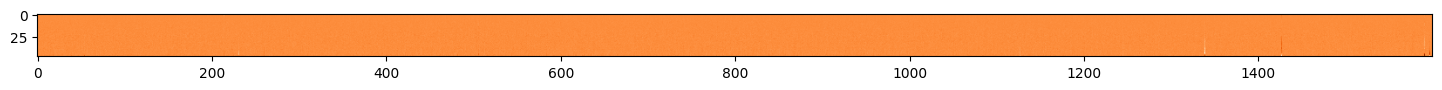

In [ ]:
plt.figure(figsize=(18, 6))
plt.imshow(all_traced[0,-1,:,:], cmap = 'Oranges_r')
plt.show()

<Axes: >

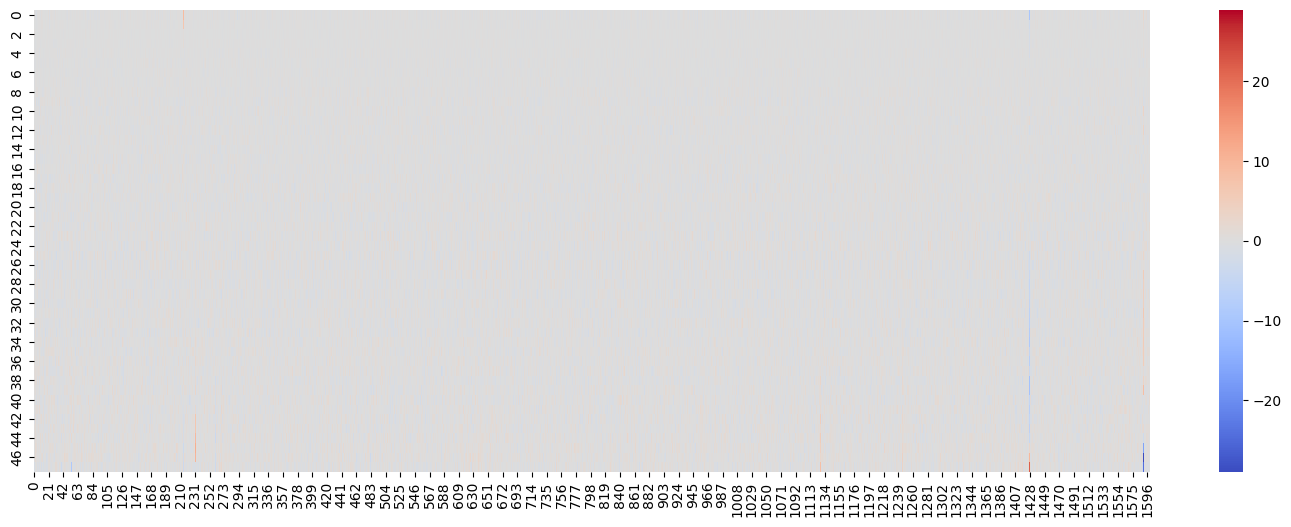

In [ ]:
import seaborn as sns

# Upscale the x-dimension
fig, ax = plt.subplots(figsize=(18, 6))  # You can adjust the figsize to your preference

# Create the heat map
sns.heatmap(all_traced[0,-1,:,:], cmap='coolwarm', ax=ax)